In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [2]:
PREVIOUS_SEASONS_MEN = False
PREVIOUS_SEASONS_WOMEN  = False 
USE_GPU = True # Turn on GPU P100 if USE_GPU=True
USE_ADDITONAL_COLUMN = False
USE_SIMPLEFLAG = False
USE_YEAR_WINFLAG = False
USE_DAYS_WINFLAG = True

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
from scipy.interpolate import UnivariateSpline
from sklearn import preprocessing
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.model_selection import KFold
from tqdm import tqdm

pd.set_option("display.max_column", 200)
pd.set_option("display.max_rows", 200)
# print(os.listdir("../input"))
xgb.__version__ # I used '1.2.0-SNAPSHOT'

'2.0.3'

In [5]:
import os

DATA_PATH = "/kaggle/input/march-machine-learning-mania-2025/"
tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv")
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
], ignore_index=True)
#  2025 데이터가 있는지 확인
if 2025 not in seeds["Season"].unique():
    print(" 2025 시즌 데이터가 없으므로 2024 데이터를 복사하여 생성합니다.")
    
    # 2024 시즌 데이터 복사
    seeds_2025 = seeds[seeds["Season"] == 2024].copy()
    seeds_2025["Season"] = 2025  # 시즌을 2025로 변경
    
    # 원본 데이터와 합치기
    seeds = pd.concat([seeds, seeds_2025], ignore_index=True)
    
    print(" 2025 시즌 데이터가 성공적으로 추가되었습니다.")
else:
    print(" 2025 시즌 데이터가 이미 존재합니다.")
    
#  최종 데이터 확인
print(seeds.tail(10))  # 마지막 10개 데이터 확인
regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
], ignore_index=True)

 2025 시즌 데이터가 이미 존재합니다.
      Season Seed  TeamID
2616    2025  Z07    1242
2617    2025  Z08    1163
2618    2025  Z09    1328
2619    2025  Z10    1116
2620    2025  Z11    1179
2621    2025  Z12    1161
2622    2025  Z13    1213
2623    2025  Z14    1423
2624    2025  Z15    1303
2625    2025  Z16    1313


In [6]:
def prepare_data(df_data, use_additional_column=False):
    df = df_data.copy()
    df.rename(columns={'WLoc': 'location'}, inplace=True)
    
    # 스왑용 데이터프레임 생성 (L→T1, W→T2 변환)
    dfswap = df[[
        'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT', 
        'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
        'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'
    ]]

    #  추가 컬럼 리스트
    additional_cols = ['WEFFG', 'WEFFG3', 'WDARE', 'WTOQUETOQUE',
                       'LEFFG', 'LEFFG3', 'LDARE', 'LTOQUETOQUE']
    
    #  추가 칼럼을 반영할지 여부 확인
    if use_additional_column:
        df = df.assign(**{col: df[col.split('_')[1]] / df[col.split('_')[1] + 'A'] for col in additional_cols})
        dfswap = dfswap.assign(**{col: dfswap[col.split('_')[1]] / dfswap[col.split('_')[1] + 'A'] for col in additional_cols})

    #  컬럼명 변환: 승리팀(W) → T1, 패배팀(L) → T2
    df.columns = df.columns.str.replace('W', 'T1_')
    df.columns = df.columns.str.replace('L', 'T2_')

    #  dfswap(패배팀을 T1으로, 승리팀을 T2로 변경)
    dfswap.columns = dfswap.columns.str.replace('L', 'T1_')
    dfswap.columns = dfswap.columns.str.replace('W', 'T2_')

    #  한 경기(W/L)를 두 개의 T1/T2 형태로 변환
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    
    #  경기 장소 변환: N → 0, H → 1, A → -1
    output.loc[output.location == 'N', 'location'] = '0'
    output.loc[output.location == 'H', 'location'] = '1'
    output.loc[output.location == 'A', 'location'] = '-1'
    output['location'] = output['location'].astype(int)

    #  점수 차이 계산 (타겟 변수로 활용 가능)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']

    #  추가 파생 변수 생성 (use_additional_column 활성화 시)
    if use_additional_column:
        output['T1_EFFG'] = output['T1_FGM'] / output['T1_FGA']
        output['T1_EFFG3'] = output['T1_FGM3'] / output['T1_FGA3']
        output['T1_DARE'] = output['T1_FGM3'] / output['T1_FGM']
        output['T1_TOQUETOQUE'] = output['T1_Ast'] / output['T1_FGM']
        
        output['T2_EFFG'] = output['T2_FGM'] / output['T2_FGA']
        output['T2_EFFG3'] = output['T2_FGM3'] / output['T2_FGA3']
        output['T2_DARE'] = output['T2_FGM3'] / output['T2_FGM']
        output['T2_TOQUETOQUE'] = output['T2_Ast'] / output['T2_FGM']

        # 분모 0일 경우 NaN 발생 → 0으로 대체
        cols_to_fill = ['T1_EFFG','T1_EFFG3','T1_DARE','T1_TOQUETOQUE',
                        'T2_EFFG','T2_EFFG3','T2_DARE','T2_TOQUETOQUE']
        output[cols_to_fill] = output[cols_to_fill].fillna(0.0)

    return output


In [7]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [8]:
base_cols = [
    'T1_Score', 'T2_Score',
    'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3',
    'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF',
    'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3',
    'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',
    'PointDiff'
]

additional_cols = [
    'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE',
    'T2_EFFG', 'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE'
]

if USE_ADDITONAL_COLUMN:
    boxscore_cols = base_cols + additional_cols
else:
    boxscore_cols = base_cols
if USE_SIMPLEFLAG:
    boxscore_cols = ['T1_Score', 'T2_Score', 'PointDiff']

In [9]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()
season_statistics.columns = [f"{col[0]}_mean" if col[1] == "mean" else col[0] for col in season_statistics.columns]
season_statistics.head(3)

<ipython-input-9-1d7ed903c056>:1: FutureWarning: The provided callable <function mean at 0x7d8681614940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()


,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714


In [10]:
season_statistics.shape

(7981, 23)

In [11]:
def get_mean_of_3_season(val_2ps, val_1ps, val_0ps, 
                         weight_2=1, weight_1=2, weight_0=3, 
                         degree_weight=1.0
                         ):
    weight_2 = weight_2**degree_weight
    weight_1 = weight_1**degree_weight
    weight_0 = weight_0**degree_weight
    if val_2ps == 0  and val_1ps == 0:
        return val_0ps
    elif val_2ps == 0:
        return (val_1ps*weight_2 + val_0ps*weight_1)/(weight_2 + weight_1)
    else:
        sum_of_values = val_2ps*weight_2 + val_1ps*weight_1 + val_0ps*weight_0
        return sum_of_values/(weight_2 + weight_1 + weight_0)

def get_3_feature(df_team, feature):
    value_2_seasons_ago = 0
    value_1_season_ago = 0
    value_0_season_ago = 0
    for _, val in df_team.iterrows():
        value_2_seasons_ago = value_1_season_ago
        value_1_season_ago = value_0_season_ago
        value_0_season_ago = val[feature]
    return value_2_seasons_ago, value_1_season_ago, value_0_season_ago

def write_mean_of_3_seasons(df, features, degree_weight=1.0):
    df_copy = df.copy()
    suffix = "_mn3s"
    
    # 1️⃣ 초기값을 0.0 (float)으로 설정하여 자동 float 변환
    for ft in features:
        df_copy[ft + suffix] = 0.0  

    for idx, val in tqdm(df_copy.iterrows(), total=len(df_copy)):
        team = val.T1_TeamID
        season = val.Season
        df_team = df_copy[(df_copy.T1_TeamID == team)&
                          (df_copy.Season <= season)&
                          (df_copy.Season > season-3)]
        
        for ft in features:
            val_2ps, val_1ps, val_0ps = get_3_feature(df_team, ft)
            ft_mean_3 = get_mean_of_3_season(val_2ps, val_1ps, val_0ps, degree_weight=degree_weight)
            
            # 2️⃣ float 변환 후 할당
            df_copy.loc[idx, ft + suffix] = float(ft_mean_3)  

    return df_copy


In [12]:
#Make two copies of the data
if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_Score_mean", "T1_FGA_mean",  "T1_FGA3_mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, degree_weight=1.0
    )
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
else:
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1[1000:1003]

,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean
1000,2006,1122,71.870968,71.258065,24.677419,54.193548,5.483871,16.387097,10.516129,14.032258,14.419355,7.000000,18.580645,25.548387,56.612903,6.548387,19.516129,12.161290,13.161290,15.290323,7.419355,2.548387,0.612903
1001,2006,1123,62.538462,65.461538,22.230769,52.192308,5.307692,14.769231,11.384615,11.500000,14.423077,6.846154,22.846154,20.076923,47.000000,6.115385,16.000000,9.500000,12.230769,14.730769,6.115385,3.230769,-2.923077
1002,2006,1124,63.176471,72.529412,21.588235,54.294118,7.882353,21.176471,10.000000,10.941176,15.235294,6.176471,20.000000,25.117647,56.764706,6.411765,17.764706,13.411765,15.352941,12.705882,6.470588,4.058824,-9.352941


In [13]:
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

# We don't have the box score statistics in the prediction bank. So drop it.
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
season_statistics_T1.head(3)

,Season,T1_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714


In [14]:
season_statistics_T1.shape

(7981, 23)

In [15]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

#  T1 팀의 정규시즌 전체 승률 계산
season_win_stats_T1 = regular_data.copy()
season_win_stats_T1['win'] = np.where(season_win_stats_T1['PointDiff'] > 0, 1, 0)
season_win_stats_T1 = season_win_stats_T1.groupby(['Season', 'T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_season')

# ✅ T2 팀의 정규시즌 전체 승률 계산
season_win_stats_T2 = regular_data.copy()
season_win_stats_T2['win'] = np.where(season_win_stats_T2['PointDiff'] < 0, 1, 0)
season_win_stats_T2 = season_win_stats_T2.groupby(['Season', 'T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_season')


In [16]:
print(season_statistics_T1.shape)  # season_statistics_T1의 크기 확인
print(season_statistics_T2.shape)  # season_statistics_T2의 크기 확인


(7981, 23)
(7981, 23)


In [17]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
if USE_YEAR_WINFLAG:
    tourney_data = pd.merge(tourney_data, season_win_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    tourney_data = pd.merge(tourney_data, season_win_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')


In [18]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(13024, 5)

In [19]:
def normalize_column(values):
    themean = np.mean(values)
    thestd = np.std(values)
    norm = (values - themean)/(thestd) 
    return(pd.DataFrame(norm))

def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = normalize_column(quality['quality'])
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    print(quality['quality'].mean(), quality['quality'].std())
    return quality

# This is metric to measure the team's strength, in this case, this is a logistic regression and we
# the coefficients
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024),
                         team_quality(2025)
                        ]).reset_index(drop=True)

# 상위 1% 값 계산
threshold = glm_quality['quality'].quantile(0.99)

# threshold를 초과하는 값들을 NaN으로 설정
glm_quality['quality'] = glm_quality['quality'].where(glm_quality['quality'] <= threshold, np.nan)

# 결과 확인
glm_quality['quality'].isnull().sum()  # NaN 값이 몇 개 있는지 확인

2.465597047334352 1.1438304462371214
2.533721582467322 0.827769814987326
0.897984455070046 0.5826397838064685
0.9243847418436626 0.38339610378961886
2.536260227037561 1.1613687897291576
2.531811489321253 1.998665490275994
0.8150475571673627 0.372651393532984
0.9951121918528179 1.6762242412225132
1.7132187587606842 2.370480419847978


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.379245291742922 1.2160048107685182


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.6097779113688953 1.0874292217515176
2.472022879362268 1.2563227778356687
0.7831527339637495 0.520314540703006
2.3166150941973216 1.300128240520105
2.563744397012746 0.9172252838069447


10

In [20]:
print(glm_quality[glm_quality['quality'] > 5])
print(glm_quality['quality'].isnull().sum())  # NaN의 개수 확인
print(glm_quality['quality'].isnull().mean())  # NaN의 비율 확인

     TeamID   quality  Season
362    1261  6.715509    2015
941    1179  5.473999    2025
10
0.010050251256281407


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [21]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data.head()
tourney_data['T1_quality'] = tourney_data['T1_quality'].fillna(0.2)
tourney_data['T2_quality'] = tourney_data['T2_quality'].fillna(0.2)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [22]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    tourney_data_with_3_seas = write_mean_of_3_seasons(tourney_data, features_for_calc, degree_weight=1.0)
    tourney_data = tourney_data_with_3_seas.copy()

tourney_data[1000:1002]

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_win_ratio_14d,T2_win_ratio_14d,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
1000,2018,136,1437,87,1347,61,1.000000,1.0,87.058824,70.882353,31.029412,61.529412,11.411765,28.676471,9.382353,16.676471,10.352941,6.676471,15.852941,26.147059,60.205882,7.0000,21.352941,9.558824,14.0000,13.117647,4.558824,2.676471,16.176471,66.937500,64.875000,23.281250,54.84375,7.656250,21.81250,10.812500,11.875000,12.000000,6.312500,16.750000,22.656250,52.781250,6.93750,20.312500,9.093750,11.281250,13.03125,5.375,3.281250,2.062500,2.645265,0.243943,1,16,-15
1001,2018,137,1120,62,1158,58,0.333333,1.0,83.375000,73.312500,27.125000,61.781250,9.750000,26.625000,12.125000,14.437500,12.250000,7.437500,19.875000,24.562500,57.781250,8.0625,22.781250,10.250000,12.8125,15.250000,6.156250,3.281250,10.062500,75.193548,69.774194,25.870968,56.16129,7.580645,20.83871,8.354839,11.064516,9.870968,5.354839,16.645161,24.645161,56.225806,7.16129,20.387097,9.516129,12.064516,12.00000,4.000,3.290323,5.419355,0.745441,0.218473,4,13,-9


In [23]:
import pandas as pd

# ✅ 특정 시드(1, 2, 3) vs 특정 시드(16, 15, 14) 필터링
filtered_df = tourney_data[
    (tourney_data["T1_seed"].isin([2])) & 
    (tourney_data["T2_seed"].isin([15]))
]

# ✅ 실제 승패 여부 계산 (T1이 이겼으면 1, 졌으면 0)
filtered_df["Win"] = (filtered_df["T1_Score"] > filtered_df["T2_Score"]).astype(int)

# ✅ 연도별 & (T1_seed, T2_seed) 별 승률 계산
win_rate_by_matchup = (
    filtered_df.groupby(["Season", "T1_seed", "T2_seed"])["Win"]
    .mean()
    .reset_index()
    .rename(columns={"Win": "WinRate"})
)

# ✅ 결과 출력
win_rate_by_matchup


<ipython-input-23-a6c3494a8066>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Win"] = (filtered_df["T1_Score"] > filtered_df["T2_Score"]).astype(int)


,Season,T1_seed,T2_seed,WinRate
0,2003,2,15,1.00
1,2004,2,15,1.00
2,2005,2,15,1.00
3,2006,2,15,1.00
4,2007,2,15,1.00
5,2008,2,15,1.00
6,2009,2,15,1.00
7,2010,2,15,1.00
8,2011,2,15,1.00
9,2012,2,15,0.50


In [24]:
MMassey = pd.read_csv(DATA_PATH + "MMasseyOrdinals.csv")
MMassey.tail(5)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
5565788,2025,133,WOL,1476,299
5565789,2025,133,WOL,1477,341
5565790,2025,133,WOL,1478,335
5565791,2025,133,WOL,1479,303
5565792,2025,133,WOL,1480,342


In [25]:
# 시즌별로 RankingDayNum == 128이 있는지 확인
season_has_128 = MMassey.groupby("Season")["RankingDayNum"].apply(lambda x: 128 in x.values)

# 결과 출력
print(season_has_128)


Season
2003    True
2004    True
2005    True
2006    True
2007    True
2008    True
2009    True
2010    True
2011    True
2012    True
2013    True
2014    True
2015    True
2016    True
2017    True
2018    True
2019    True
2020    True
2021    True
2022    True
2023    True
2024    True
2025    True
Name: RankingDayNum, dtype: bool


In [26]:
# 시즌별로 128이 몇 번 등장하는지 확인
season_128_counts = MMassey[MMassey["RankingDayNum"] == 128].groupby("Season").size()

# 결과 출력
print(season_128_counts)
season_128_counts = MMassey[MMassey["RankingDayNum"] == 128].groupby("Season").size()

Season
2003      981
2004      978
2005     6810
2006     7376
2007      336
2008     9131
2009     1721
2010      694
2011     8330
2012      689
2013     3494
2014    21164
2015    19781
2016    20834
2017    22985
2018    21926
2019    22663
2020    21960
2021    17759
2022    20480
2023    22631
2024    19985
2025    19702
dtype: int64


In [27]:
# TeamID별, Season별로 DayNum이 128인 데이터 개수 확인
team_season_daynum_counts = MMassey[MMassey["RankingDayNum"] == 128].groupby(["TeamID", "Season"]).size()

# 결과 출력
print(team_season_daynum_counts)


TeamID  Season
1101    2014      54
        2015      56
        2016      59
        2017      65
        2018      62
                  ..
1477    2025      52
1478    2024      55
        2025      54
1479    2025      54
1480    2025      54
Length: 7980, dtype: int64


In [28]:
team_id = 1101  # 원하는 TeamID로 변경
season = 2024   # 원하는 시즌

# 특정 팀, 특정 시즌에서 DayNum == 128인 데이터 필터링
team_128_data = MMassey[(MMassey["TeamID"] == team_id) & 
                         (MMassey["Season"] == season) & 
                         (MMassey["RankingDayNum"] == 128)]

# 결과 확인
print(team_128_data)


         Season  RankingDayNum SystemName  TeamID  OrdinalRank
5223888    2024            128        7OT    1101          228
5224275    2024            128        ARG    1101          214
5224637    2024            128        BAR    1101          206
5224999    2024            128        BBT    1101          213
5225361    2024            128        BIH    1101          194
5225723    2024            128        BMN    1101          220
5226085    2024            128        BNZ    1101          218
5226447    2024            128        BWE    1101          203
5226809    2024            128        COL    1101          209
5227171    2024            128        DCI    1101          158
5227558    2024            128        DII    1101          206
5227920    2024            128        DOK    1101          214
5228282    2024            128        DOL    1101          207
5228644    2024            128         DP    1101          220
5229006    2024            128        DUN    1101      

In [29]:
# 각 시즌, 팀별로 RankingDayNum == 128의 평균 랭킹을 계산
MMassey_avg = MMassey[MMassey["RankingDayNum"] == 128].groupby(["TeamID", "Season"], as_index=False)["OrdinalRank"].mean()

# 컬럼명 변경 (평균 랭킹 값이란 의미를 명확하게 하기 위해)
MMassey_avg.rename(columns={"OrdinalRank": "AvgOrdinalRank_128"}, inplace=True)

# 결과 확인
print(MMassey_avg.head())
rankings_T1 = MMassey_avg.rename(columns={"TeamID": "T1_TeamID", "AvgOrdinalRank_128": "T1_AvgOrdinalRank_128"})
rankings_T2 = MMassey_avg.rename(columns={"TeamID": "T2_TeamID", "AvgOrdinalRank_128": "T2_AvgOrdinalRank_128"})
tourney_data = pd.merge(tourney_data, rankings_T1, on=["Season", "T1_TeamID"], how="left")

# T2 팀의 평균 랭킹을 tourney_data에 병합
tourney_data = pd.merge(tourney_data, rankings_T2, on=["Season", "T2_TeamID"], how="left")

   TeamID  Season  AvgOrdinalRank_128
0    1101    2014          337.833333
1    1101    2015          329.642857
2    1101    2016          309.322034
3    1101    2017          295.138462
4    1101    2018          261.435484


In [30]:
tourney_data.shape

(2764, 57)

In [31]:
# 데이터 로드
sub = pd.read_csv('../input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv')

# 먼저 T1_TeamID, T2_TeamID, Season을 생성해야 함
sub["Season"] = sub["ID"].apply(lambda x: x[:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)

print(len(sub))
# 남자 팀들끼리 경기만 포함 (T1_TeamID, T2_TeamID가 2000 미만)
sub_men = sub[(sub["T1_TeamID"] < 2000) & (sub["T2_TeamID"] < 2000)].copy()  # 🔥 .copy() 추가
print(len(sub_men))
print(sub_men.shape)  # 필터링 후 데이터 크기 확인

print(sub_men.shape)  # 필터링 후 데이터 크기 확인

# 남자 팀들끼리 경기만 포함 (T1_TeamID, T2_TeamID가 2000 미만)
print(sub_men.shape)  # 필터링 후 데이터 크기 확인

sub_men["Season"] = sub_men["ID"].apply(lambda x: x[0:4]).astype(int)
sub_men["T1_TeamID"] = sub_men["ID"].apply(lambda x: x[5:9]).astype(int)
sub_men["T2_TeamID"] = sub_men["ID"].apply(lambda x: x[10:14]).astype(int)
print(len(sub_men))
sub_men = pd.merge(sub_men, season_statistics_T1, on = ['Season', 'T1_TeamID'], how='left')
sub_men = pd.merge(sub_men, season_statistics_T2, on = ['Season', 'T2_TeamID'], how='left')
print(len(sub_men))
sub_men = pd.merge(sub_men, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') 
sub_men = pd.merge(sub_men, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(len(sub_men))
sub_men = pd.merge(sub_men, seeds_T1, on = ['Season', 'T1_TeamID'], how='left')
sub_men = pd.merge(sub_men, seeds_T2, on = ['Season', 'T2_TeamID'], how='left')
sub_men["Seed_diff"] = sub_men["T1_seed"] - sub_men["T2_seed"]
print(len(sub_men))
sub_men = pd.merge(sub_men, rankings_T1, on=["Season", "T1_TeamID"], how="left")
sub_men = pd.merge(sub_men, rankings_T2, on=["Season", "T2_TeamID"], how="left")

print(len(sub_men))
print(season_statistics_T2.shape) 

131407
66066
(66066, 5)
(66066, 5)
(66066, 5)
66066
66066
66066
66066
66066
(7981, 23)


In [32]:
print(sub_men.T2_quality.isnull().sum())
sub_men["T1_quality"] = sub_men["T1_quality"].fillna(0.2)
sub_men["T2_quality"] = sub_men["T2_quality"].fillna(0.2)
print(sub_men.T2_quality.isnull().sum())

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    sub_men = write_mean_of_3_seasons(sub, features_for_calc, degree_weight=1.0)
    sub_men = sub_men.copy()
sub.head(3)

54566
0


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104


In [33]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2764.000000
mean        0.000000
std        14.548408
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [34]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"] + \
    ["T1_AvgOrdinalRank_128", "T2_AvgOrdinalRank_128"]  # 🚀 Massey Ordinals 추가

if USE_DAYS_WINFLAG:
    features = features + list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999])



if USE_YEAR_WINFLAG:
    features = features + list(season_win_stats_T1.columns[2:999]) + \
    list(season_win_stats_T2.columns[2:999])
    
len(features)

51

In [35]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [36]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [37]:
param = {} 
# param['objective'] = 'reg:linear'  # 현재 사용하지 않음 (회귀 문제 아님)
param['eval_metric'] = 'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05  # 학습률 (기본 0.02 권장)
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10  # 병렬 트리 개수 (10 추천)
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3
param['verbosity'] = 1  # 최신 XGBoost에서는 사용 안 함 (경고 발생 가능)

# ✅ GPU 활성화 여부 확인 후 설정 적용
if USE_GPU:
    param.update({
        'tree_method': 'hist',
        'device' : 'cuda'  # GPU 사용하여 학습 가속화
    })

# ✅ 파라미터 출력 (GPU 활성화 여부 확인)
print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'verbosity': 1, 'tree_method': 'hist', 'device': 'cuda'}


In [38]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.48239+0.06504	test-mae:11.49160+0.27363
[50]	train-mae:8.72305+0.08522	test-mae:9.11702+0.32196
[100]	train-mae:8.32440+0.09394	test-mae:9.06512+0.36556
[113]	train-mae:8.24437+0.09360	test-mae:9.06621+0.36882
Fold repeater 1
[0]	train-mae:11.48622+0.11074	test-mae:11.49260+0.45488
[50]	train-mae:8.73139+0.07713	test-mae:9.09554+0.34169
[100]	train-mae:8.33656+0.07764	test-mae:9.01674+0.35161
[150]	train-mae:8.04837+0.07759	test-mae:9.00408+0.35369
[169]	train-mae:7.95237+0.07608	test-mae:9.00946+0.35603
Fold repeater 2
[0]	train-mae:11.48818+0.10228	test-mae:11.49340+0.40828
[50]	train-mae:8.72949+0.04745	test-mae:9.10777+0.27141
[100]	train-mae:8.32690+0.04927	test-mae:9.03368+0.23493
[148]	train-mae:8.05758+0.05470	test-mae:9.03071+0.23050
Fold repeater 3
[0]	train-mae:11.48590+0.07124	test-mae:11.49137+0.31324
[50]	train-mae:8.72979+0.06214	test-mae:9.09423+0.24046
[100]	train-mae:8.33343+0.06462	test-mae:9.01833+0.25975
[150]	train-mae:8.04468+0.06

In [39]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([89, 145, 124, 127, 182, 127, 112, 95, 135, 104],
 [9.060703727698598,
  9.003841977437197,
  9.026112125511188,
  9.01091876282035,
  8.962636620996914,
  9.000609910368121,
  9.009728064200138,
  9.061935898937907,
  8.986713135280578,
  9.028486204410825])

In [40]:
oof_preds = [] #T1_score-T2_score의 점수차이
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.60157223e+01  8.12920380e+00  9.01398849e+00 -6.28818417e+00
  1.19662886e+01  2.52909660e+00 -6.66379035e-01  1.27864923e+01
  2.69480896e+00 -1.92669082e+00 -1.32007909e+00 -3.53042603e-01
  1.90535774e+01 -2.35970902e+00  1.88557587e+01  1.23091688e+01
  9.21159267e+00  5.03370667e+00  2.35346746e+00 -2.74926162e+00
  5.43670511e+00  7.86560106e+00  2.01882100e+00  5.38680851e-01
 -1.45832562e+00  2.60839200e+00  1.80451374e+01  8.72083473e+00
  1.51659994e+01  9.81057167e+00 -2.06326580e+00 -2.96386456e+00
  7.55315685e+00 -6.68749809e-01 -1.43814754e+00  1.93964291e+01
  9.83905411e+00 -7.76123285e+00 -6.97628856e-01 -2.36974359e+00
  1.63325477e+00  7.42616415e+00  1.00241804e+01  1.26922207e+01
  6.95727491e+00  6.29995394e+00 -1.20073318e+01  6.60860395e+00
  1.34783440e+01  1.23107452e+01  1.83628006e+01 -9.432

Fold repeater 1


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.72479689e-01  1.66774769e+01 -1.94289184e+00  8.77841568e+00
  8.17451477e+00  6.60177803e+00  3.72474289e+00  6.73192358e+00
  8.81536865e+00  7.27770662e+00 -8.56384850e+00 -2.76179165e-02
  2.44485893e+01  1.93285573e+00  9.42462444e+00 -1.26221165e-01
  4.45948219e+00  4.96384525e+00 -6.82984734e+00 -2.18935108e+00
  3.16091537e-01 -1.21926701e+00 -4.25643730e+00 -3.39976978e+00
  1.05616436e+01 -4.66498756e+00  5.30430698e+00 -2.85130918e-01
  9.56975651e+00 -2.66070628e+00  9.47969818e+00  2.15088005e+01
  6.44182920e+00  1.08070278e+01  1.76315384e+01  1.93450832e+00
  2.20822983e+01  8.22430897e+00 -1.05692654e+01  1.78253422e+01
  3.19518280e+00  7.16010618e+00  3.43596363e+00 -1.98987722e+00
 -6.16686535e+00 -4.95903063e+00  7.18135309e+00 -2.67679453e+00
  1.19708562e+00 -1.19427907e+00  8.58050251e+00  5.182

Fold repeater 2


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.04548299e+00  6.55787516e+00 -4.63656139e+00 -3.54400754e+00
 -2.26034212e+00  1.15719831e+00  7.31701899e+00  8.97510815e+00
  5.36299133e+00 -2.71016550e+00 -6.51268339e+00  2.05207157e+01
  1.93657856e+01  9.41754937e-01  1.85414848e+01  1.19066930e+00
  9.60527420e+00  6.62948561e+00  2.38722372e+00  4.68923044e+00
  8.82994843e+00  1.02779369e+01 -1.31302118e+00  1.54339075e+00
  4.70430326e+00 -6.19618130e+00 -9.81340647e-01 -4.65528584e+00
 -1.78415632e+00  3.10533595e+00  9.46386242e+00  5.65640688e+00
  2.97191978e+00 -3.87298465e+00  3.50166202e+00  2.08273926e+01
  5.28484011e+00  1.58205163e+00  6.23276377e+00  3.34080839e+00
  8.13628578e+00  6.79649258e+00 -1.95401382e+00  1.28033471e+00
  8.96651554e+00 -1.02590199e+01  3.63648200e+00  6.17271805e+00
  8.10842323e+00 -3.91220880e+00 -4.56736279e+00  6.368

Fold repeater 3


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-9.94932950e-01 -9.94400406e+00  2.39846915e-01  1.50643435e+01
  9.41836643e+00  6.92219198e-01 -7.59239054e+00  7.50656176e+00
  1.83363616e-01 -8.55718327e+00 -3.12626767e+00 -1.25024223e+00
  2.14776111e+00  1.08087921e+00  1.12255239e+01  1.33285179e+01
  1.91854572e+01  2.09311438e+00  2.78984904e+00 -2.12979603e+00
 -2.06661582e+00 -2.66765451e+00  1.01410904e+01 -4.44522715e+00
  3.40019917e+00  4.30903149e+00 -1.62357521e+00  8.57258320e+00
 -5.92736387e+00  7.68275499e+00  9.65087414e+00 -7.44762945e+00
  2.06975031e+00  9.53727663e-01 -2.33361602e+00  2.19948330e+01
  2.04104633e+01  7.14190388e+00  2.71893597e+00  6.20767450e+00
 -4.77823400e+00  7.88286924e+00  7.87128496e+00  5.82840538e+00
 -2.12544870e+00  1.34871550e+01 -8.37037146e-01  4.84177208e+00
  4.26636362e+00  5.11470175e+00 -1.24662590e+00 -6.119

Fold repeater 4


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.23910360e+01  5.71086931e+00  1.91699295e+01  8.39404881e-01
  2.07853432e+01  1.65775089e+01  6.19565964e+00  9.13616657e+00
 -6.02475357e+00  2.75295138e+00  2.07470112e+01 -6.90919936e-01
  6.71409750e+00  1.31235731e+00  1.21016717e+00  2.00160351e+01
  1.39480143e+01  1.25147390e+00  1.88539314e+01  1.91609898e+01
 -8.66298962e+00 -4.05631125e-01  1.44294128e+01 -3.51425385e+00
 -2.15415645e+00 -7.60401666e-01  5.32951832e+00  9.95962334e+00
 -7.89993668e+00  1.45816469e+00 -7.57067919e-01 -1.58066034e+00
  4.89566326e+00  9.54712963e+00 -2.89014769e+00 -8.76096535e+00
  2.05122242e+01  2.95859528e+00  1.57706032e+01  3.80187869e+00
  3.77227783e+00  7.88441420e+00 -7.87292385e+00 -3.37544560e+00
  7.38597918e+00  6.53441143e+00 -1.13905592e+01 -2.43559211e-01
  3.40947342e+00  4.12302160e+00  5.17152309e+00  1.859

Fold repeater 5


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-4.00498152e+00  2.19787210e-01  5.74461603e+00 -5.70441008e+00
  1.80096531e+01 -2.25176001e+00  7.43076849e+00  1.28024483e+01
  7.75183392e+00  3.22676349e+00 -4.58203554e+00  7.74493170e+00
 -2.10136104e+00  2.08713398e+01  5.30410624e+00 -1.02286899e+00
  1.32002907e+01  1.77939415e+01  1.44488311e+00  4.11537075e+00
  4.44674921e+00 -3.18535352e+00  2.31286411e+01  1.89808311e+01
  2.19920483e+01  1.68665543e+01  8.18180442e-01 -1.54115629e+00
  4.78115940e+00  6.46710682e+00  6.24210644e+00  1.05946283e+01
  1.03044577e+01  1.37553203e+00  1.32087975e+01 -1.38636696e+00
  6.90340996e+00  4.60471535e+00 -1.93337643e+00  5.80089152e-01
  7.21026325e+00  1.15477490e+00 -9.41342831e+00 -5.74014997e+00
  2.34648323e+00 -1.09945498e+01  1.68109856e+01  6.36547136e+00
  9.48957920e+00  8.31274223e+00 -1.03462398e+00 -2.557

Fold repeater 6


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 7.11966097e-01  3.62742186e+00  7.13916922e+00 -4.62666321e+00
 -4.01579428e+00  2.17367210e+01  1.13335419e+00  1.68029194e+01
  8.40676975e+00  3.15347981e+00 -6.56379128e+00  3.40418148e+00
  5.87947845e+00  6.60051060e+00  5.70557356e+00 -1.46173692e+00
  4.50523281e+00 -1.08201347e-01  7.47635126e+00  1.36050501e+01
  1.99822083e+01  2.01009293e+01 -9.44089031e+00  2.25936711e-01
  3.01862985e-01 -2.42372131e+00  2.60849237e+00 -5.05137742e-01
  5.18551493e+00  8.20940590e+00  9.22043419e+00  2.10540733e+01
 -2.50664806e+00 -1.80891335e+00  1.61596737e+01  1.28905563e+01
  7.56098700e+00  1.03439817e+01  1.10496731e+01  1.05011778e+01
  5.69394827e+00 -1.53814030e+00 -4.53036636e-01  8.57316780e+00
  2.17056026e+01  2.20432591e+00  3.26921612e-01 -1.35921454e+00
  7.19434083e-01 -7.08968306e+00  1.67070160e+01 -5.554

Fold repeater 7


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -0.58246154  -2.4846635   20.351986    -3.187563    17.313341
  -0.59074235   1.6996759    5.784351    -8.620316     5.4449224
  -5.40617      5.336021     8.943424    -0.554852     9.322369
  -5.387385     0.90646446   3.4986496    8.357014    21.165195
  19.335241    -1.3033447    8.945641     4.141286    -0.2557347
   4.471178     5.0061836   -3.3157482    8.694339     9.455427
   0.11186925   5.7774563   -0.65038973   2.2319279   -2.1925662
  -8.43788      2.2798157    6.080132    -1.0745411    6.754175
  -5.6444163    7.2280235   13.082371     5.9249673   -1.9584378
  14.712474     0.20691322  16.072481    -1.296473     4.258158
  -2.4305644    9.64294     -0.71341354   0.9786353    4.768239
   5.57687      3.157513     2.358186    -0.02629619  14.095002
  14.179975    -0.9596202   10.243806    -4.7975483   -1.662377

Fold repeater 8


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -2.5692263   -7.1858706   15.075661    12.992423     1.3576738
   8.372045     8.799529     7.2048545    5.773136    -8.125826
   2.3645334   -2.35372      2.4110513    1.6364576   12.317108
   3.278493    10.5443325    0.52264076  10.1298       0.71422774
   4.6239085    5.1483693   -4.113303     7.8062506   -3.0154939
   1.9752779   10.3288765    1.8181839   21.787382    -5.7909603
   7.11164     12.481789     7.7658663    9.422911     0.0314734
   4.023156     5.17708      7.600541     8.706834    20.739231
  20.275764     2.4380872    5.842662    -1.8755548    6.5384545
   1.7113482    6.961328     2.2970765    2.508726    12.573025
   4.9825583   14.349474    11.741673    21.107737    -1.3846998
  10.42238     -0.18404475   1.5307543    3.8052404    2.7492342
  -0.65928173  21.302332     7.537416    10.660482     8.4

Fold repeater 9


<ipython-input-40-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.37778008e+00  1.53292360e+01 -3.91482401e+00  1.65372925e+01
  2.19127102e+01 -1.49473190e+00  5.28938150e+00  6.04323435e+00
 -7.57365751e+00 -2.67340779e+00  1.88550496e+00  1.91078453e+01
  8.44341159e-01  2.16222668e+01  4.54367638e+00  7.21503878e+00
  6.47313058e-01  3.52662110e+00  5.79043627e+00  4.88524771e+00
  5.02616835e+00  7.63352680e+00  1.96112430e+00  3.38487911e+00
  1.85385609e+01  1.69377022e+01  1.08260679e+01 -6.40768632e-02
  1.09925079e+01  5.37827253e+00 -1.26559186e+00  2.08831158e+01
  1.59421911e+01  3.60858703e+00 -1.29049528e+00  6.01356411e+00
  4.72192496e-01  2.17894703e-01 -1.74188483e+00  7.26480532e+00
  1.67887449e+00 -6.71709156e+00  1.17283068e+01 -1.31370163e+00
 -2.91901183e+00  6.34947836e-01 -6.54020786e+00  1.90133648e+01
  1.68276672e+01  9.49139023e+00  7.58925486e+00  4.805

In [41]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0))) #점수차이와 실제 승패 묶음
    dat = sorted(dat, key = lambda x: x[0]) #예측된 점수 차이를 기준으로 정렬 / Spline의 경우 정렬되어 있어야 학습이 잘됨.
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5574317983067002
logloss of cvsplit 1: 0.5541425692204438
logloss of cvsplit 2: 0.5570777462573354
logloss of cvsplit 3: 0.5545697713076952
logloss of cvsplit 4: 0.5541655160728939
logloss of cvsplit 5: 0.5546806080070402
logloss of cvsplit 6: 0.5551382167527424
logloss of cvsplit 7: 0.5583494027671432
logloss of cvsplit 8: 0.5531384686576029
logloss of cvsplit 9: 0.5563367555243546


In [42]:
# ✅ 최근 14일 경기 통계 데이터를 T1, T2에 대해 병합
sub_men = pd.merge(sub_men, last14days_stats_T1, on=["Season", "T1_TeamID"], how="left")
sub_men = pd.merge(sub_men, last14days_stats_T2, on=["Season", "T2_TeamID"], how="left")

Xsub = sub_men[features].values
dtest = xgb.DMatrix(Xsub)

In [43]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [44]:
# 예측한 점수 차이를 ScoreDiff 컬럼에 추가
sub_men["ScoreDiff"] = np.mean([sub_models[i].predict(dtest) for i in range(repeat_cv)], axis=0)


In [45]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.0,1.0))
#  점수 차이에 따른 확률 보정
sub_men.loc[sub_men["ScoreDiff"] >= 23, "Pred"] = 1.0
sub_men.loc[sub_men["ScoreDiff"] <= -23, "Pred"] = 0.0
sub_men.loc[(sub_men.T1_seed == 1) & (sub_men.T2_seed == 16), "Pred"] = 1.0
sub_men.loc[(sub_men.T1_seed == 16) & (sub_men.T2_seed == 1), "Pred"] = 0.0
sub_men["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub_men[['ID','Pred']].to_csv("submission_men.csv", index = None)

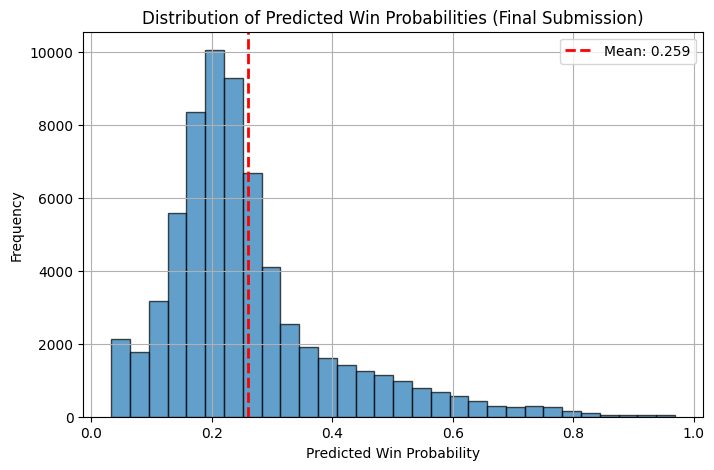

In [46]:
# 예측 확률 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(sub_men["Pred"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(sub_men["Pred"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean: {sub_men['Pred'].mean():.3f}")
plt.xlabel("Predicted Win Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Win Probabilities (Final Submission)")
plt.legend()
plt.grid(True)
plt.show()


# Now Women Part


In [47]:
import os

DATA_PATH = "/kaggle/input/march-machine-learning-mania-2025/"
tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv")
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
], ignore_index=True)
#  2025 데이터가 있는지 확인
if 2025 not in seeds["Season"].unique():
    print(" 2025 시즌 데이터가 없으므로 2024 데이터를 복사하여 생성합니다.")
    
    # 2024 시즌 데이터 복사
    seeds_2025 = seeds[seeds["Season"] == 2024].copy()
    seeds_2025["Season"] = 2025  # 시즌을 2025로 변경
    
    # 원본 데이터와 합치기
    seeds = pd.concat([seeds, seeds_2025], ignore_index=True)
    
    print(" 2025 시즌 데이터가 성공적으로 추가되었습니다.")
else:
    print(" 2025 시즌 데이터가 이미 존재합니다.")
    
#  최종 데이터 확인
print(seeds.tail(10))  # 마지막 10개 데이터 확인
regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv")
], ignore_index=True)

 2025 시즌 데이터가 이미 존재합니다.
      Season Seed  TeamID
1734    2025  Z07    3329
1735    2025  Z08    3143
1736    2025  Z09    3280
1737    2025  Z10    3355
1738    2025  Z11    3293
1739    2025  Z12    3193
1740    2025  Z13    3251
1741    2025  Z14    3195
1742    2025  Z15    3117
1743    2025  Z16    3422


In [48]:
def prepare_data(df_data, use_additional_column=False):
    df = df_data.copy()
    df.rename(columns={'WLoc': 'location'}, inplace=True)
    
    # 스왑용 데이터프레임 생성 (L→T1, W→T2 변환)
    dfswap = df[[
        'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT', 
        'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
        'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'
    ]]

    #  추가 컬럼 리스트
    additional_cols = ['WEFFG', 'WEFFG3', 'WDARE', 'WTOQUETOQUE',
                       'LEFFG', 'LEFFG3', 'LDARE', 'LTOQUETOQUE']
    
    #  추가 칼럼을 반영할지 여부 확인
    if use_additional_column:
        df = df.assign(**{col: df[col.split('_')[1]] / df[col.split('_')[1] + 'A'] for col in additional_cols})
        dfswap = dfswap.assign(**{col: dfswap[col.split('_')[1]] / dfswap[col.split('_')[1] + 'A'] for col in additional_cols})

    #  컬럼명 변환: 승리팀(W) → T1, 패배팀(L) → T2
    df.columns = df.columns.str.replace('W', 'T1_')
    df.columns = df.columns.str.replace('L', 'T2_')

    #  dfswap(패배팀을 T1으로, 승리팀을 T2로 변경)
    dfswap.columns = dfswap.columns.str.replace('L', 'T1_')
    dfswap.columns = dfswap.columns.str.replace('W', 'T2_')

    #  한 경기(W/L)를 두 개의 T1/T2 형태로 변환
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    
    #  경기 장소 변환: N → 0, H → 1, A → -1
    output.loc[output.location == 'N', 'location'] = '0'
    output.loc[output.location == 'H', 'location'] = '1'
    output.loc[output.location == 'A', 'location'] = '-1'
    output['location'] = output['location'].astype(int)

    #  점수 차이 계산 (타겟 변수로 활용 가능)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']

    #  추가 파생 변수 생성 (use_additional_column 활성화 시)
    if use_additional_column:
        output['T1_EFFG'] = output['T1_FGM'] / output['T1_FGA']
        output['T1_EFFG3'] = output['T1_FGM3'] / output['T1_FGA3']
        output['T1_DARE'] = output['T1_FGM3'] / output['T1_FGM']
        output['T1_TOQUETOQUE'] = output['T1_Ast'] / output['T1_FGM']
        
        output['T2_EFFG'] = output['T2_FGM'] / output['T2_FGA']
        output['T2_EFFG3'] = output['T2_FGM3'] / output['T2_FGA3']
        output['T2_DARE'] = output['T2_FGM3'] / output['T2_FGM']
        output['T2_TOQUETOQUE'] = output['T2_Ast'] / output['T2_FGM']

        # 분모 0일 경우 NaN 발생 → 0으로 대체
        cols_to_fill = ['T1_EFFG','T1_EFFG3','T1_DARE','T1_TOQUETOQUE',
                        'T2_EFFG','T2_EFFG3','T2_DARE','T2_TOQUETOQUE']
        output[cols_to_fill] = output[cols_to_fill].fillna(0.0)

    return output


In [49]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [50]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()
season_statistics.columns = [f"{col[0]}_mean" if col[1] == "mean" else col[0] for col in season_statistics.columns]
season_statistics.head(3)

<ipython-input-50-1d7ed903c056>:1: FutureWarning: The provided callable <function mean at 0x7d8681614940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()


,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean
0,2010,3102,51.821429,71.785714,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,14.964286,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,62.233333,59.633333,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,17.533333,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,64.137931,67.000000,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,20.413793,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069


In [51]:
#Make two copies of the data
if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_Score_mean", "T1_FGA_mean",  "T1_FGA3_mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, degree_weight=1.0
    )
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
else:
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1[1000:1003]

,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean
1000,2012,3434,51.482759,57.034483,18.586207,50.931034,3.965517,15.724138,10.724138,10.482759,17.586207,7.241379,13.344828,21.275862,56.896552,5.931034,20.275862,12.310345,12.413793,14.448276,8.206897,2.896552,-5.551724
1001,2012,3435,71.903226,60.870968,26.354839,56.612903,5.322581,14.387097,12.935484,15.419355,17.322581,7.838710,16.290323,21.967742,59.161290,4.580645,16.129032,14.612903,11.322581,17.387097,8.161290,2.935484,11.032258
1002,2012,3436,58.821429,62.071429,21.035714,61.392857,5.750000,20.107143,15.678571,12.357143,18.500000,8.607143,19.428571,20.750000,55.714286,3.392857,11.321429,13.107143,11.178571,17.071429,10.142857,3.928571,-3.250000


In [52]:
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

# We don't have the box score statistics in the prediction bank. So drop it.
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
season_statistics_T1.head(3)

,Season,T1_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean
0,2010,3102,51.821429,71.785714,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,14.964286,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,62.233333,59.633333,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,17.533333,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,64.137931,67.000000,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,20.413793,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069


In [53]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

#  T1 팀의 정규시즌 전체 승률 계산
season_win_stats_T1 = regular_data.copy()
season_win_stats_T1['win'] = np.where(season_win_stats_T1['PointDiff'] > 0, 1, 0)
season_win_stats_T1 = season_win_stats_T1.groupby(['Season', 'T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_season')

# ✅ T2 팀의 정규시즌 전체 승률 계산
season_win_stats_T2 = regular_data.copy()
season_win_stats_T2['win'] = np.where(season_win_stats_T2['PointDiff'] < 0, 1, 0)
season_win_stats_T2 = season_win_stats_T2.groupby(['Season', 'T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_season')


In [54]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
if USE_YEAR_WINFLAG:
    tourney_data = pd.merge(tourney_data, season_win_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    tourney_data = pd.merge(tourney_data, season_win_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')


In [55]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(8628, 5)

In [56]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024),
                         team_quality(2025)
                        ]).reset_index(drop=True)

# 상위 1% 값 계산
threshold = glm_quality['quality'].quantile(0.99)

# threshold를 초과하는 값들을 NaN으로 설정
glm_quality['quality'] = glm_quality['quality'].where(glm_quality['quality'] <= threshold, np.nan)

# 결과 확인
glm_quality['quality'].isnull().sum()  # NaN 값이 몇 개 있는지 확인

0.9962327093948863 0.9690510918495937
0.8204741108694886 0.3758754360477374


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.5904309115275326 1.5759856311334262
2.60211510442703 1.2454941822369756
2.479794441085722 1.3310146273820123


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.465738426076537 1.1995056765474497
2.6999213440916576 0.5907778295888815
2.591675882005314 1.1200657162413663
2.5707810825909503 1.0827956444675733
2.6563515636730313 0.7684602645389189


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


0.9201262259580119 0.4693538806515419
0.798279209793948 0.32608579145443867
1.0706185340555308 0.9401053102285044
1.0068696990396486 0.8124799045343851
1.0059523832713484 0.6609676107537137


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


10

In [57]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data.head()
tourney_data['T1_quality'] = tourney_data['T1_quality'].fillna(0.2)
tourney_data['T2_quality'] = tourney_data['T2_quality'].fillna(0.2)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1998,W01,3330,1
1,1998,W02,3163,2
2,1998,W03,3112,3
3,1998,W04,3301,4
4,1998,W05,3272,5


In [58]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    tourney_data_with_3_seas = write_mean_of_3_seasons(tourney_data, features_for_calc, degree_weight=1.0)
    tourney_data = tourney_data_with_3_seas.copy()

tourney_data[1000:1002]

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_win_ratio_14d,T2_win_ratio_14d,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
1000,2011,141,3199,59,3208,61,0.0,0.500000,73.900000,64.733333,26.033333,59.333333,5.333333,14.766667,14.566667,13.533333,18.600000,7.800000,17.566667,23.433333,61.233333,5.533333,17.300000,13.166667,12.20000,17.966667,7.766667,3.733333,9.166667,64.774194,58.483871,24.516129,60.548387,4.741935,17.00000,16.258065,12.419355,15.935484,8.580645,15.774194,21.129032,57.516129,5.806452,19.709677,13.580645,12.290323,17.00000,6.774194,2.225806,6.290323,1.023350,0.950507,3,6,-3
1001,2011,141,3462,75,3257,85,1.0,0.333333,74.413793,55.103448,28.068966,61.068966,5.517241,16.689655,14.310345,16.724138,14.896552,7.655172,12.827586,20.344828,59.724138,5.655172,19.551724,11.827586,12.62069,16.068966,8.068966,2.965517,19.310345,70.531250,59.281250,25.781250,58.437500,6.937500,19.78125,12.812500,14.875000,17.718750,11.343750,17.625000,20.906250,53.562500,5.500000,18.375000,12.500000,12.656250,21.96875,7.843750,2.593750,11.250000,1.039314,0.986014,2,7,-5


In [59]:
# 데이터 로드
sub = pd.read_csv('../input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv')

# 먼저 T1_TeamID, T2_TeamID, Season을 생성해야 함
sub["Season"] = sub["ID"].apply(lambda x: x[:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)

# 남자 팀들끼리 경기만 포함 (T1_TeamID, T2_TeamID가 2000 미만)
sub_women = sub[(sub["T1_TeamID"] >= 2000) & (sub["T2_TeamID"] >= 2000)].copy()  # 🔥 .copy() 추가

print(sub_women.shape)  # 필터링 후 데이터 크기 확인

print(sub_women.shape)  # 필터링 후 데이터 크기 확인

# 남자 팀들끼리 경기만 포함 (T1_TeamID, T2_TeamID가 2000 미만)
print(sub_women.shape)  # 필터링 후 데이터 크기 확인

sub_women["Season"] = sub_women["ID"].apply(lambda x: x[0:4]).astype(int)
sub_women["T1_TeamID"] = sub_women["ID"].apply(lambda x: x[5:9]).astype(int)
sub_women["T2_TeamID"] = sub_women["ID"].apply(lambda x: x[10:14]).astype(int)
sub_women = pd.merge(sub_women, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub_women = pd.merge(sub_women, season_statistics_T2, on = ['Season', 'T2_TeamID'], how='left')
print(sub_women.shape)
sub_women = pd.merge(sub_women, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') 
sub_women = pd.merge(sub_women, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(sub_women.shape)
sub_women = pd.merge(sub_women, seeds_T1, on = ['Season', 'T1_TeamID'], how='left')
sub_women = pd.merge(sub_women, seeds_T2, on = ['Season', 'T2_TeamID'], how='left')
print(sub_women.shape)
sub_women["Seed_diff"] = sub_women["T1_seed"] - sub_men["T2_seed"]
print(sub_women.shape)
sub_women = pd.merge(sub_women, rankings_T1, on=["Season", "T1_TeamID"], how="left")
sub_women = pd.merge(sub_women, rankings_T2, on=["Season", "T2_TeamID"], how="left")



(65341, 5)
(65341, 5)
(65341, 5)
(65341, 47)
(65341, 49)
(65341, 51)
(65341, 52)


In [60]:
print(sub_women.T2_quality.isnull().sum())
sub_women["T1_quality"] = sub_women["T1_quality"].fillna(0.2)
sub_women["T2_quality"] = sub_women["T2_quality"].fillna(0.2)
print(sub_women.T2_quality.isnull().sum())

if PREVIOUS_SEASONS_WOMEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    sub_women = write_mean_of_3_seasons(sub, features_for_calc, degree_weight=1.0)
    sub_women = sub_women.copy()
sub.head(3)

53491
0


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104


In [61]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    1788.000000
mean        0.000000
std        21.232346
min       -89.000000
25%       -13.250000
50%         0.000000
75%        13.250000
max        89.000000
dtype: float64

In [62]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

if USE_DAYS_WINFLAG:
    features = features + list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999])



if USE_YEAR_WINFLAG:
    features = features + list(season_win_stats_T1.columns[2:999]) + \
    list(season_win_stats_T2.columns[2:999])
    
len(features)

49

In [63]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [64]:
 tourney_data[features]

,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T1_seed,T2_seed,Seed_diff,T1_quality,T2_quality,T1_win_ratio_14d,T2_win_ratio_14d
0,72.093750,56.843750,26.093750,56.343750,2.468750,8.656250,12.187500,14.687500,16.875000,6.968750,14.125000,21.125000,62.625000,5.531250,19.937500,12.687500,9.500000,15.718750,6.656250,1.875000,15.250000,73.454545,60.575758,25.848485,61.575758,8.818182,24.848485,13.878788,14.636364,15.636364,10.393939,16.393939,22.939394,56.696970,4.151515,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788,4,13,-9,1.097234,0.385861,0.500000,0.750000
1,70.769231,59.500000,25.884615,61.538462,5.461538,17.461538,14.730769,14.461538,16.961538,7.730769,16.576923,21.576923,58.692308,5.423077,16.846154,12.076923,11.653846,18.346154,7.615385,4.384615,11.269231,72.300000,60.300000,25.833333,62.266667,6.866667,19.200000,13.500000,15.600000,16.033333,9.833333,16.233333,21.833333,59.700000,5.733333,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000,8,9,-1,1.070782,1.038745,0.500000,0.333333
2,71.593750,55.062500,26.843750,63.750000,4.562500,14.468750,17.718750,14.250000,17.906250,13.375000,17.687500,18.843750,53.593750,5.312500,16.593750,12.500000,11.375000,23.218750,7.531250,3.281250,16.531250,62.833333,55.133333,22.200000,60.100000,4.900000,16.100000,14.966667,11.600000,15.533333,10.100000,18.833333,19.000000,49.933333,2.866667,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000,2,15,-13,1.158375,0.141439,1.000000,1.000000
3,74.466667,60.100000,26.400000,59.200000,6.100000,16.100000,14.400000,15.333333,19.033333,8.833333,17.133333,21.333333,59.566667,5.300000,18.433333,13.400000,12.233333,19.200000,8.200000,2.133333,14.366667,74.258065,64.322581,27.161290,62.516129,3.935484,12.451613,14.806452,14.516129,17.096774,7.096774,16.032258,23.903226,64.064516,4.806452,17.387097,13.709677,10.741935,17.451613,8.193548,4.225806,9.935484,3,14,-11,1.093277,0.374885,0.000000,0.800000
4,68.033333,58.366667,23.833333,60.266667,6.333333,20.066667,15.766667,15.866667,16.300000,13.366667,18.033333,19.733333,48.866667,5.400000,18.833333,12.100000,13.266667,24.600000,7.933333,3.233333,9.666667,68.181818,57.909091,23.424242,55.696970,6.545455,19.030303,10.515152,14.454545,13.484848,7.878788,13.969697,20.575758,58.939394,6.333333,21.363636,14.333333,10.727273,15.727273,7.151515,2.303030,10.272727,5,12,-7,1.086265,1.086377,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,74.677419,62.161290,26.516129,62.290323,7.548387,21.225806,10.451613,14.806452,11.806452,7.935484,16.129032,22.548387,58.129032,5.451613,17.774194,7.612903,13.354839,14.548387,6.322581,2.677419,12.516129,79.878788,56.969697,30.545455,61.636364,7.090909,19.787879,8.121212,19.303030,12.363636,9.818182,14.363636,21.090909,58.212121,6.121212,21.575758,7.484848,11.757576,15.969697,5.212121,2.181818,22.909091,1,3,-2,1.165559,1.086279,1.000000,1.000000
1784,86.696970,62.545455,31.212121,66.818182,4.242424,13.212121,14.969697,16.545455,15.212121,10.787879,16.090909,22.818182,62.121212,6.272727,21.181818,8.787879,10.818182,18.939394,8.000000,3.818182,24.151515,92.848485,71.909091,33.121212,65.818182,11.303030,29.606061,9.121212,21

In [65]:
import pandas as pd

# ✅ 특정 시드(1, 2, 3) vs 특정 시드(16, 15, 14) 필터링
filtered_df = tourney_data[
    (tourney_data["T1_seed"].isin([4])) & 
    (tourney_data["T2_seed"].isin([13]))
]

# ✅ 실제 승패 여부 계산 (T1이 이겼으면 1, 졌으면 0)
filtered_df["Win"] = (filtered_df["T1_Score"] > filtered_df["T2_Score"]).astype(int)

# ✅ 연도별 & (T1_seed, T2_seed) 별 승률 계산
win_rate_by_matchup = (
    filtered_df.groupby(["Season", "T1_seed", "T2_seed"])["Win"]
    .mean()
    .reset_index()
    .rename(columns={"Win": "WinRate"})
)

# ✅ 결과 출력
win_rate_by_matchup


<ipython-input-65-20eb04910e77>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Win"] = (filtered_df["T1_Score"] > filtered_df["T2_Score"]).astype(int)


,Season,T1_seed,T2_seed,WinRate
0,2010,4,13,1.00
1,2011,4,13,1.00
2,2012,4,13,0.75
3,2013,4,13,1.00
4,2014,4,13,1.00
5,2015,4,13,1.00
6,2016,4,13,1.00
7,2017,4,13,1.00
8,2018,4,13,1.00
9,2019,4,13,1.00


In [66]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:16.35994+0.04554	test-mae:16.37525+0.18100
[50]	train-mae:9.92295+0.08175	test-mae:10.46223+0.39517
[100]	train-mae:9.21581+0.08245	test-mae:10.13992+0.34145
[150]	train-mae:8.80231+0.08938	test-mae:10.12067+0.34149
[154]	train-mae:8.77233+0.08960	test-mae:10.12072+0.33953
Fold repeater 1
[0]	train-mae:16.35639+0.07492	test-mae:16.36979+0.30302
[50]	train-mae:9.92628+0.09520	test-mae:10.46130+0.32165
[100]	train-mae:9.21949+0.10815	test-mae:10.14636+0.42300
[150]	train-mae:8.80573+0.10695	test-mae:10.11734+0.42168
[152]	train-mae:8.79142+0.10781	test-mae:10.11749+0.42343
Fold repeater 2
[0]	train-mae:16.36448+0.07701	test-mae:16.37461+0.30676
[50]	train-mae:9.93566+0.08618	test-mae:10.40500+0.38113
[100]	train-mae:9.22338+0.07187	test-mae:10.06312+0.30846
[150]	train-mae:8.80980+0.05832	test-mae:10.03106+0.25725
[200]	train-mae:8.46541+0.05812	test-mae:10.02335+0.22096
[212]	train-mae:8.38940+0.05945	test-mae:10.02422+0.21794
Fold repeater 3
[0]	train-mae:

In [67]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([130, 128, 187, 190, 141, 148, 157, 147, 122, 146],
 [10.116884596073808,
  10.110380558923714,
  10.018903984606919,
  10.083323127869857,
  10.144400301596136,
  10.052935048863878,
  10.134637607412285,
  10.136639970786963,
  10.04363623976562,
  10.12467859440116])

In [68]:
oof_preds = [] #T1_score-T2_score의 점수차이
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 8.87545204e+00  8.66316605e+00  1.86034870e+01  8.17440414e+00
  3.27069511e+01  4.14605293e+01  1.32131681e+01  2.23277378e+00
  2.50809937e+01  1.52893674e+00  5.60762882e-01  9.71294880e+00
  6.91991282e+00  1.99785805e+01  4.13143396e+00 -1.08975315e+01
  1.70232868e+01  2.27287745e+00  3.13135123e+00  4.02647400e+01
  5.05505896e+00  1.63661690e+01 -1.37596154e+00  2.41916156e+00
 -1.16789198e+01  1.58262396e+01  1.72560730e+01 -7.26945639e+00
 -7.25701952e+00  1.17788887e+01  1.22575893e+01  2.82264919e+01
  1.43681421e+01  3.25622864e+01  2.15944901e+01 -1.01525135e+01
  1.20024090e+01  3.05605841e+00  1.36500349e+01  1.18254194e+01
  1.58511448e+01 -3.62732434e+00 -9.24491787e+00  1.47237225e+01
  1.55732346e+00  8.11539745e+00  8.19806671e+00  3.44384842e+01
  5.64451170e+00 -4.28124332e+00  2.56356735e+01  4.719

Fold repeater 1


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.65434666e+01  2.47600727e+01  1.83617172e+01 -2.81858873e+00
  2.01379442e+00  1.00879116e+01  3.15093555e+01  5.83819342e+00
 -6.89147377e+00  5.82664347e+00  1.99889927e+01  2.12056217e+01
  7.55029774e+00  3.47262154e+01  4.05176392e+01  4.36159897e+00
  3.48709755e+01  1.94567323e+00  2.73381577e+01  2.04622536e+01
 -7.63080597e+00 -7.59894562e+00  8.70738506e-01  9.88272285e+00
 -4.35908651e+00  2.08436661e+01  3.72742987e+00  2.84217300e+01
  1.40293157e+00  2.66829185e+01  1.23051529e+01  1.33462086e+01
 -1.13547583e+01  1.28533421e+01  2.18265171e+01  4.39366007e+00
  4.40262794e+01 -9.12080479e+00  2.48701496e+01  2.54154015e+01
  5.50693607e+00  1.08885641e+01  1.42253580e+01  6.66556168e+00
  1.07329798e+00 -2.79285598e+00 -1.52505088e+00  2.95543060e+01
  4.41504440e+01  3.33630490e+00  7.42781496e+00  1.055

Fold repeater 2


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.15308914e+01  1.06311617e+01  7.92219496e+00  3.28087425e+01
  2.49291706e+00  3.36095390e+01  5.13783693e+00  1.53182516e+01
 -2.82944536e+00  3.21287274e+00  3.63059692e+01  3.84027219e+00
  4.11717987e+01  5.44656515e+00  2.29196811e+00  6.42957354e+00
  1.84048061e+01  2.10169754e+01  1.06996751e+00  1.12045221e+01
  1.74533415e+00 -3.17424625e-01 -9.50029087e+00  2.98075352e+01
  1.34365244e+01  3.89215050e+01  7.18743324e-01  3.31054840e+01
 -4.78427553e+00  1.21477432e+01  1.16393542e+00  1.17794142e+01
 -2.95432615e+00  1.85108929e+01  1.99130421e+01  6.83103323e+00
  1.31605759e+01  3.06409717e+00  1.05100260e+01  4.92324352e-01
  1.09506845e+01  9.86236286e+00  1.61256123e+01 -9.31719971e+00
  1.05891228e+01  1.40954933e+01  1.83375072e+01  6.34787130e+00
  4.51705627e+01  3.07024717e+00  2.61011620e+01  1.698

Fold repeater 3


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 23.303093    10.168706     6.488864    -2.4409945    2.6904387
  25.905909     1.9525385   34.911552   -10.224275    -5.087406
  19.082045    12.127117     8.624161     5.523726    11.846558
  17.651905     6.3263617   42.435047     2.2219803   15.553041
  23.409235    11.865154    13.526521    25.379257    21.083273
  15.850269    -2.4617996   29.44277      2.110252    -5.2835693
   2.5215552   10.791734     7.8021417    6.016435     9.540064
  -2.1230047   -0.13743713  28.91418      3.4285402  -12.534304
  24.650705    11.30534      2.5013924   20.241882    -0.5190103
   2.1195154    4.104332    10.975994    -0.6248009   -4.031367
  30.695875    35.74811      7.929668    10.512423    24.136938
   0.658147    -0.0741821   13.278969    -2.9991286    1.8487073
  -5.5692453   25.914417    15.555514    10.6802845    5.186066

Fold repeater 4


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.16526222e+00  3.49984550e+01  5.82837296e+00  1.96961575e+01
  2.37568474e+01  2.02815771e+00  7.47959852e+00  1.81218452e+01
  4.62554359e+00  1.40203209e+01  2.17830963e+01  2.78779011e+01
  7.19508028e+00  4.76765251e+00  1.15431223e+01  1.79256496e+01
  1.31648693e+01  1.06339035e+01 -6.36832297e-01  2.18404140e+01
  1.93550167e+01  4.03139496e+00 -1.57607770e+00  2.83429947e+01
  3.57111049e+00  2.91376305e+01  2.14218807e+01  2.38387794e+01
  2.93989449e+01  3.08721185e+00  6.50562811e+00  1.02821589e+00
  2.73007259e+01 -2.84642506e+00  2.25309258e+01  6.45431232e+00
 -1.09880371e+01  1.20426331e+01  1.83940163e+01  2.42292428e+00
 -1.42117178e+00 -1.68520957e-01  3.04056015e+01  5.86635113e+00
  4.38298321e+00 -3.00082844e-02  1.23164263e+01  4.47424698e+00
  3.09153004e+01  6.04412508e+00 -2.02666593e+00  1.653

Fold repeater 5


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -0.8484606   27.372118    22.179705     6.9573846    3.8245208
   0.9724773   -1.2049103   31.372261    -9.4803705    5.515781
  18.922903    -4.0221725   10.024553    36.57969     17.435205
  26.488281    14.270658    28.351465    -5.407507     2.066373
  17.646214    15.727058   -10.130337     3.6044335   29.685177
  23.898026    12.026743    -2.1711912   23.844952    25.778273
  16.761597    16.762556     3.0824459   -1.1419132   23.501698
 -10.789556    26.148413    21.385351    28.671297    -4.645825
  10.246622     7.4552956   30.956593    22.740925    15.197871
  18.112217     0.42358547  30.087385     0.17819475  -7.486742
   7.164611    26.126432    22.379324    24.969145    29.260878
   9.691669     7.9032955   -7.1675553    6.4237614    9.197499
  28.689648    29.020464    12.648069    13.5860195   14.092767
  

Fold repeater 6


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 16.52095      8.611631    26.655035    25.036415    -5.3775406
   0.6673622   -4.0817504   32.04897     20.163082    -2.6255114
  20.966927    -5.4167275   -3.3323705   -1.2027045   19.462666
   2.3446178    9.314784     2.4894128   22.324593    20.604448
  -5.7473893   -0.23648027   0.23973617   2.7509413   30.07568
   0.22664592  38.669384    12.728017    36.01117      2.085969
   2.1935682   20.091024    20.023521     2.896061   -10.3160925
  19.250704     2.179546     8.928417    -6.304199   -20.807276
  -2.688932     0.5167255    6.706439    18.429008    11.825411
  -9.414716     6.484597    24.270458    29.72262      1.2599994
   4.149727    13.218792     8.853634    22.670416     9.456993
  34.191456    24.677393    19.118874    -4.6903715   29.470942
   7.662837     3.7231805   13.269563     3.6461816    1.7874912

Fold repeater 7


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.80421047e+01  8.99732685e+00  9.85662556e+00  1.05585739e-01
  3.60469360e+01  4.61408882e+01  2.22143688e+01  5.26784086e+00
  1.73278260e+00  1.60093517e+01 -3.77045560e+00 -8.26212978e+00
  2.10332432e+01  2.10646420e+01  2.77635918e+01  3.75900536e+01
  8.16271973e+00  8.07709026e+00 -2.33053774e-01  1.65286674e+01
  2.52286510e+01 -7.09742260e+00  9.39889491e-01  1.36849346e+01
  9.16029453e+00  2.21067238e+01 -1.71010911e-01  1.86998043e+01
  4.26602707e+01 -6.48342896e+00  2.04306769e+00  1.32009239e+01
 -5.55901337e+00  2.58771992e+00  1.31541338e+01  1.03052654e+01
  5.95957661e+00  2.25156188e+00  1.30475140e+01  1.62816262e+00
 -2.75575280e-01  2.25707531e+01 -1.15932426e+01  2.48641193e-01
  6.79910064e-01  1.42145109e+01  1.29718423e+00 -1.11039038e+01
  2.36640491e+01  1.03547897e+01  1.39337282e+01  2.405

Fold repeater 8


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.22112393e-01  2.57241287e+01  2.57359505e+01  5.50366497e+00
  3.21976733e+00  2.18246651e+00  3.05689468e+01  1.60528603e+01
 -2.98203874e+00  1.90533371e+01  1.86899300e+01  1.52269974e+01
  2.84630241e+01 -4.80711508e+00  3.31992416e+01  2.00919609e+01
  1.55397673e+01  1.97245827e+01 -6.09592772e+00  4.57743216e+00
  1.63221657e+00  1.52549229e+01 -6.26221037e+00  4.39846087e+00
 -5.10398388e-01  2.42653770e+01  1.21756516e+01  1.06268606e+01
  3.08633003e+01 -2.85896254e+00  1.07535315e+00 -1.27584190e+01
 -6.15248919e-01 -2.60824621e-01  2.45397530e+01 -1.30826244e+01
  1.29750290e+01  1.84207726e+01  1.84571915e+01  1.44118032e+01
 -7.31172979e-01  4.83180046e+00  1.72940941e+01 -8.50535011e+00
  2.44346291e-01  8.34307766e+00  1.87871132e+01  2.73949776e+01
 -9.74378943e-01  3.38917542e+01  1.24412451e+01 -1.081

Fold repeater 9


<ipython-input-68-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.68298340e+01  6.98119354e+00  1.86439629e+01  2.16335034e+00
  9.92191887e+00  3.18510556e+00 -8.49154377e+00 -1.21553063e+00
  8.52524281e+00  2.64720612e+01 -2.45190054e-01  6.22066641e+00
 -5.90123940e+00  3.48698273e+01  2.17764740e+01 -3.27160098e-02
  1.89552581e+00  1.04143918e+00  1.85282688e+01 -1.04816236e+01
  1.93924522e+01  1.15890284e+01  1.82103691e+01 -7.19098663e+00
 -6.82772684e+00  2.33395309e+01  3.08782616e+01  1.27444658e+01
  1.24957409e+01  3.76870499e+01  7.43759775e+00 -5.27077854e-01
  2.83259373e+01  1.30842867e+01  4.16505289e+00  1.13525877e+01
 -4.04090786e+00 -3.79435681e-02  1.43861361e+01  3.05416756e+01
 -3.03531647e+00  1.32158079e+01  2.32922897e+01  4.19962120e+00
  1.57861137e+01  4.10771906e-01  5.48370028e+00  1.67316544e+00
  2.53537560e+01 -1.32851386e+00  2.42173615e+01  1.757

In [69]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0))) #점수차이와 실제 승패 묶음
    dat = sorted(dat, key = lambda x: x[0]) #예측된 점수 차이를 기준으로 정렬 / Spline의 경우 정렬되어 있어야 학습이 잘됨.
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.43765635187289503
logloss of cvsplit 1: 0.43514370417119225
logloss of cvsplit 2: 0.4346066298066808
logloss of cvsplit 3: 0.4332425947816463
logloss of cvsplit 4: 0.4362357964320623
logloss of cvsplit 5: 0.4332125040269298
logloss of cvsplit 6: 0.438492096089326
logloss of cvsplit 7: 0.43828538322594823
logloss of cvsplit 8: 0.43370376993134724
logloss of cvsplit 9: 0.43559527384088403


In [70]:
# ✅ 최근 14일 경기 통계 데이터를 T1, T2에 대해 병합
sub_women = pd.merge(sub_women, last14days_stats_T1, on=["Season", "T1_TeamID"], how="left")
sub_women = pd.merge(sub_women, last14days_stats_T2, on=["Season", "T2_TeamID"], how="left")

Xsub = sub_women[features].values
dtest = xgb.DMatrix(Xsub)

In [71]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [72]:
sub_women["ScoreDiff"] = np.mean([sub_models[i].predict(dtest) for i in range(repeat_cv)], axis=0)


In [73]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub_women["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
sub_women.loc[sub_women["ScoreDiff"] >= 23, "Pred"] = 1.0
sub_women.loc[sub_women["ScoreDiff"] <= -23, "Pred"] = 0.0

# ✅ 시드 기반 보정
sub_women.loc[(sub_women.T1_seed == 1) & (sub_women.T2_seed == 16), "Pred"] = 1.0
sub_women.loc[(sub_women.T1_seed == 16) & (sub_women.T2_seed == 1), "Pred"] = 0.0

sub_women.loc[(sub_women.T1_seed == 2) & (sub_women.T2_seed == 15), "Pred"] = 1.0
sub_women.loc[(sub_women.T1_seed == 15) & (sub_women.T2_seed == 2), "Pred"] = 0.0

sub_women.loc[(sub_women.T1_seed == 3) & (sub_women.T2_seed == 14), "Pred"] = 1.0
sub_women.loc[(sub_women.T1_seed == 14) & (sub_women.T2_seed == 3), "Pred"] = 0.0
sub_women[['ID','Pred']].to_csv("submission_women.csv", index = None)

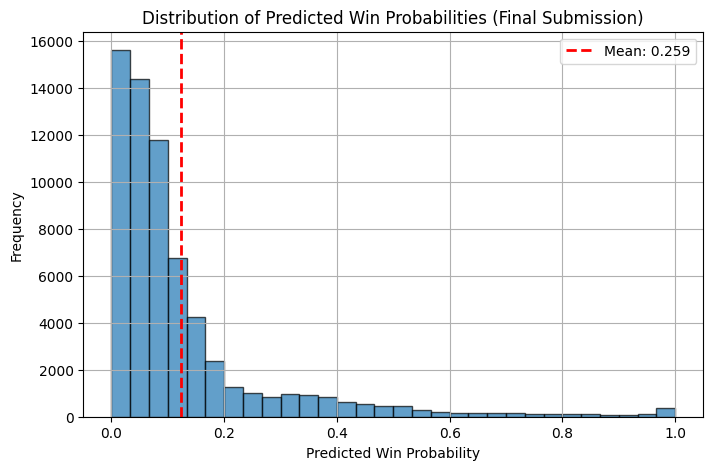

In [74]:
# 예측 확률 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(sub_women["Pred"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(sub_women["Pred"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean: {sub_men['Pred'].mean():.3f}")
plt.xlabel("Predicted Win Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Win Probabilities (Final Submission)")
plt.legend()
plt.grid(True)
plt.show()


In [75]:
import pandas as pd

# CSV 파일 불러오기
sub_men = pd.read_csv("submission_men.csv")
sub_women = pd.read_csv("submission_women.csv")

# 데이터 합치기 (밑으로 추가)
sub_final = pd.concat([sub_men, sub_women], ignore_index=True)

# 최종 CSV 저장
sub_final.to_csv("submission_final_real.csv", index=False)


In [76]:
print(len(sub_final)) 
print(len(sub_men))
print(len(sub_women))


131407
66066
65341
